<a href="https://colab.research.google.com/github/sidh26/DL-Assignments/blob/master/Expt%2011%20-%20Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let us first look differentiating among the terms classification, localization and detection. We hear these terms often in the image processing world and these are distinctive to each other in their applications.

1. Classification — Refers to identifying if a given object is present inside an image or not. Common example: Cat or no-cat.
2. Localization — Refers to not only identifying is a given object is present inside an image, but also distinguishing the object’s location using a bounding box.
3. Detection — Simply refers to multiple localizations in a single image.

#YOLO: Real-Time Object Detection

You only look once (YOLO) is a state-of-the-art, real-time object detection system. On a Pascal Titan X it processes images at 30 FPS and has a mAP of 57.9% on COCO test-dev.

#How It Works (By Joseph Redmon - https://pjreddie.com/darknet/yolo/)

Prior detection systems repurpose classifiers or localizers to perform detection. They apply the model to an image at multiple locations and scales. High scoring regions of the image are considered detections.

We use a totally different approach. We apply a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.



Our model has several advantages over classifier-based systems. It looks at the whole image at test time so its predictions are informed by global context in the image. It also makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image. This makes it extremely fast, more than 1000x faster than R-CNN and 100x faster than Fast R-CNN. See our paper for more details on the full system.

##What's New in Version 3?

YOLOv3 uses a few tricks to improve training and increase performance, including: multi-scale predictions, a better backbone classifier, and more.

#Check CUDA release version

In [1]:
!/usr/local/cuda/bin/nvcc --version


!wget http://people.cs.uchicago.edu/~kauffman/nvidia/cudnn/cudnn-10.2-linux-x64-v7.6.5.32.tgz 


# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xvzf /content/cudnn-10.2-linux-x64-v7.6.5.32.tgz
!chmod a+r /content/cuda/include/cudnn.h
!cat /content/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
--2020-04-10 19:49:22--  http://people.cs.uchicago.edu/~kauffman/nvidia/cudnn/cudnn-10.2-linux-x64-v7.6.5.32.tgz
Resolving people.cs.uchicago.edu (people.cs.uchicago.edu)... 128.135.164.80
Connecting to people.cs.uchicago.edu (people.cs.uchicago.edu)|128.135.164.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548210361 (523M) [application/x-gzip]
Saving to: ‘cudnn-10.2-linux-x64-v7.6.5.32.tgz.1’

cudnn-10.2-linux-x6 100%[===================>] 522.81M  8.86MB/s    in 71s     

2020-04-10 19:50:34 (7.35 MB/s) - ‘cudnn-10.2-linux-x64-v7.6.5.32.tgz.1’ saved [548210361/548210361]

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.6.5
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PAT

#Detection Using A Pre-Trained Model

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/pjreddie/darknet'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q $git_repo_url
  #!cd $project_name && pip install -q -r requirement.txt




In [3]:
%cd /content/darknet/


/content/darknet


In [4]:
#Compile Darknet
!make

make: Nothing to be done for 'all'.


#Download the Yolo darknet. 

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights



--2020-04-10 19:51:01--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  1.35MB/s    in 3m 58s  

2020-04-10 19:55:00 (1018 KB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [6]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

#See the results

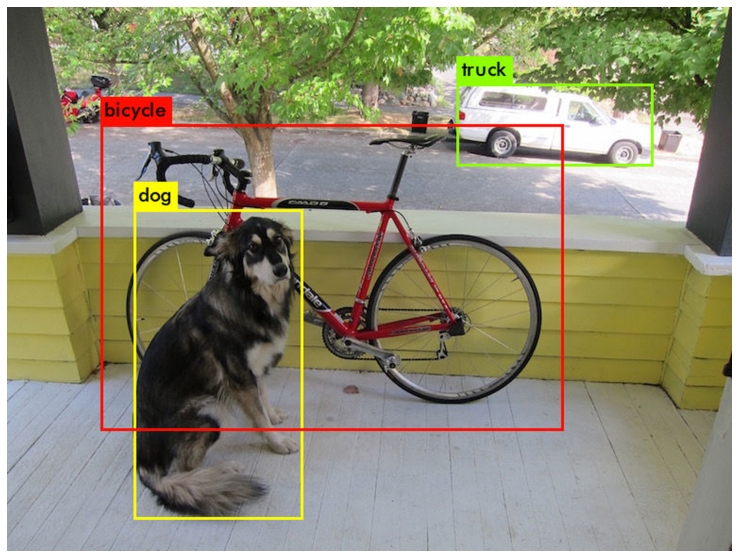

In [7]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
# Show the result using the helper imgShow()
imShow('predictions.jpg')

#Explanation

Darknet prints out the objects it detected, its confidence, and how long it took to find them. We didn't compile Darknet with OpenCV so it can't display the detections directly. Instead, it saves them in predictions.png. You can open it to see the detected objects. Since we are using Darknet on the CPU it takes around 6-12 seconds per image. If we use the GPU version it would be much faster.

I've included some example images to try in case you need inspiration. Try data/eagle.jpg, data/dog.jpg, data/person.jpg, or data/horses.jpg!

In [8]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/eagle.jpg -dont-show

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

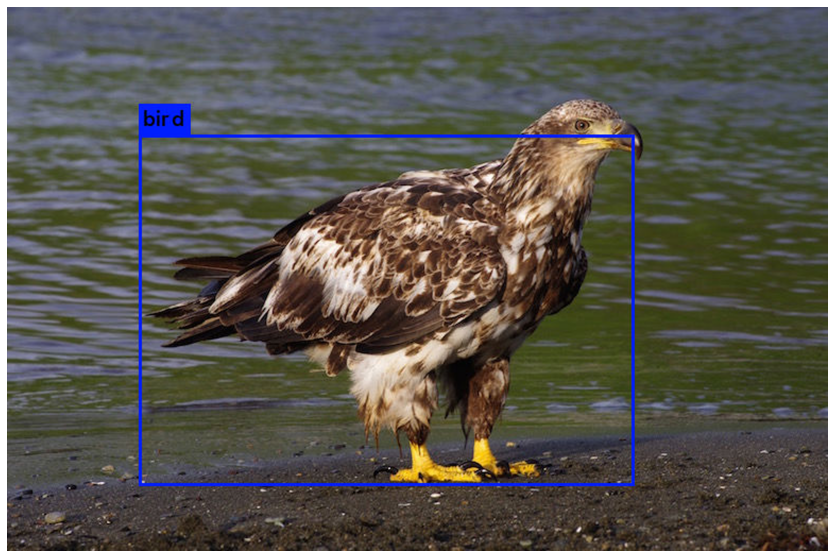

In [9]:
# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [10]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg 

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

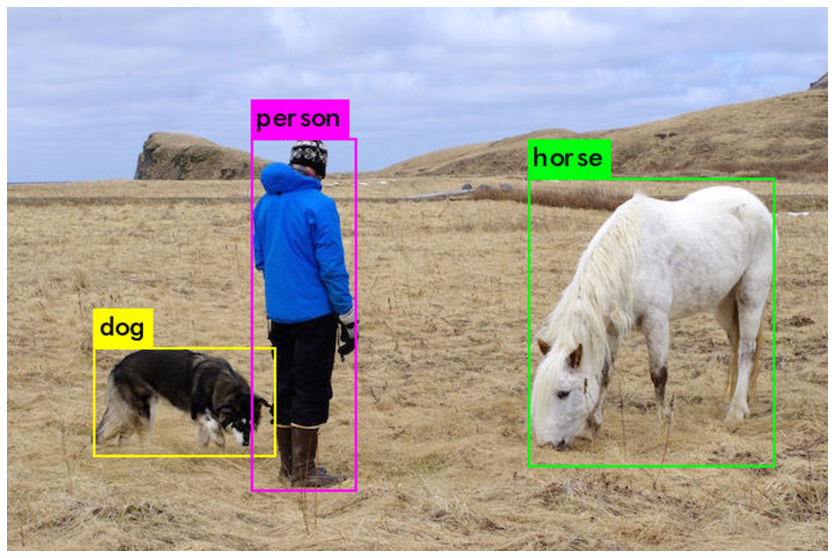

In [11]:
# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [12]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/horses.jpg 

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

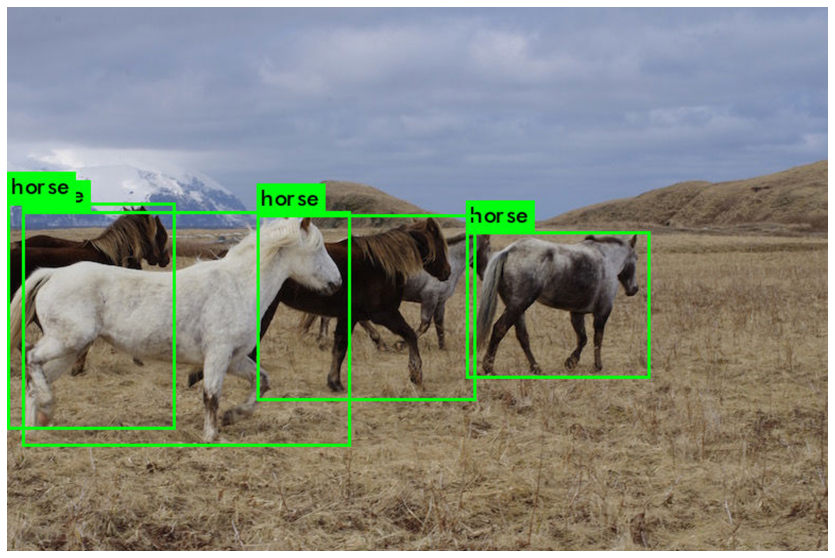

In [13]:
# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [14]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/kite.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

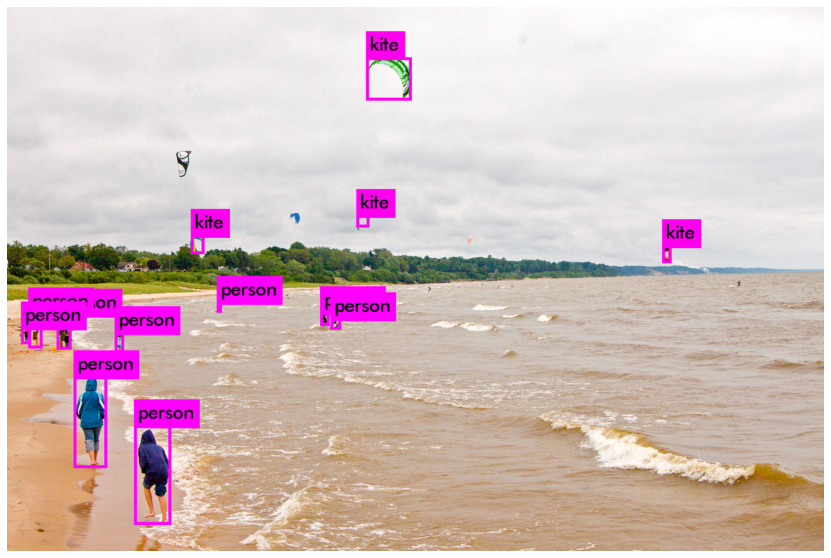

In [15]:
# Show the result using the helper imgShow()
imShow('predictions.jpg')

In [16]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/scream.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

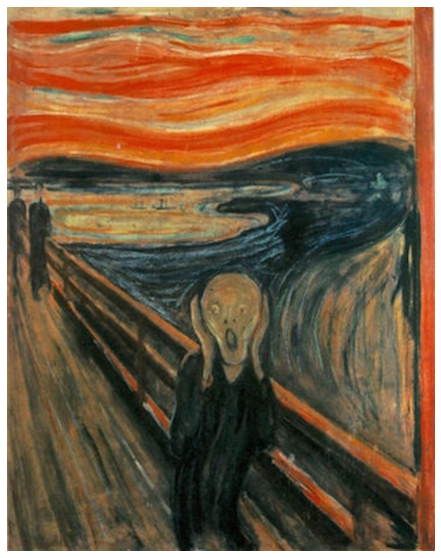

In [17]:
# Show the result using the helper imgShow()
imShow('predictions.jpg')

#Changing The Detection Threshold (Warning: Very slow may take 20+ mins )

By default, YOLO only displays objects detected with a confidence of .25 or higher. You can change this by passing the -thresh <val> flag to the yolo command. For example, to display all detection you can set the threshold to 0:

In [0]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg -thresh 0
# interrupted as it crashed colab repeatedly

#Tiny YOLOv3

We have a very small model as well for constrained environments, yolov3-tiny. To use this model, first download the weights:

In [18]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2020-04-10 19:58:41--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights.1’

yolov3-tiny.weights 100%[===================>]  33.79M  1.14MB/s    in 29s     

2020-04-10 19:59:11 (1.15 MB/s) - ‘yolov3-tiny.weights.1’ saved [35434956/35434956]



In [19]:
!./darknet detect cfg/yolov3-tiny.cfg yolov3-tiny.weights data/dog.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

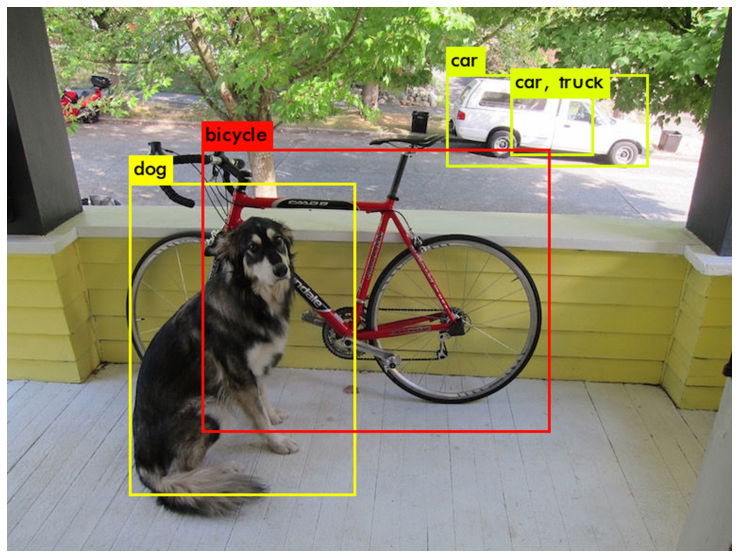

In [20]:
# Show the result using the helper imgShow()
imShow('predictions.jpg')

#Thank you